# Step 1: Preparing the data

In [1]:
import json

In [2]:
import torch as pt

In [3]:

# returns JSON object as 
# a dictionary
train_inputs = []
train_outputs = []
with open('Dialogue-Evaluation-with-BERT/dataset/train.json', 'r') as f:
    for line in f:
        line_dict = json.loads(line)
        if len(line_dict['context']) > 1:
            for resp in line_dict['positive_responses']:
                train_inputs.extend([line_dict['context'][-1], resp])
                train_outputs.extend([pt.tensor([float(1)])])

            for resp in line_dict['adversarial_negative_responses']:
                train_inputs.extend([line_dict['context'][-1], resp])
                train_outputs.extend([pt.tensor([float(0)])])

        # else:
        #     print(line_dict['context'])



In [4]:
len(train_inputs), len(train_outputs)*2

(202360, 202360)

In [5]:

# returns JSON object as 
# a dictionary
test_inputs = []
test_outputs = []

with open('Dialogue-Evaluation-with-BERT/dataset/test.json', 'r') as f:
    for line in f:
        line_dict = json.loads(line)
        if len(line_dict['context']) > 1:
            for resp in line_dict['positive_responses']:
                test_inputs.extend([line_dict['context'][-1], resp])
                test_outputs.extend([pt.tensor([float(1)])])

            for resp in line_dict['adversarial_negative_responses']:
                test_inputs.extend([line_dict['context'][-1], resp])
                test_outputs.extend([pt.tensor([float(0)])])
        else:
            print(line_dict['context'])



In [6]:
len(test_inputs), len(test_outputs)*2

(22840, 22840)

In [7]:
import torch as pt
device = pt.device("mps") if pt.backends.mps.is_available() else pt.device("cpu")
device

device(type='mps')

# Step 2: Create the embeddings

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("avsolatorio/GIST-Embedding-v0", revision=None)

# model = SentenceTransformer('all-MiniLM-L6-v2')
model.to(device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytr

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Usually takes 7 m

In [9]:
train_plain_embedings = model.encode(train_inputs)

In [10]:
import numpy as np
import torch as pt
import random

train_embeddings = []

for idx in range(len(train_plain_embedings)//2):
    train_embeddings.append(pt.tensor(np.concatenate((train_plain_embedings[idx*2], train_plain_embedings[idx*2 + 1]))))

train_ds = []
train_ds = list(zip(train_embeddings, train_outputs))
random.shuffle(train_ds)
len(train_ds)

101180

In [11]:
test_plain_embeddings = model.encode(test_inputs)

In [12]:
test_embeddings = []

for idx in range(len(test_plain_embeddings)//2):
    test_embeddings.append(pt.tensor(np.concatenate((test_plain_embeddings[idx*2], test_plain_embeddings[idx*2 + 1]))))

test_ds = []
test_ds = list(zip(test_embeddings, test_outputs))
random.shuffle(test_ds)
len(test_ds)

11420

In [13]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class ComplexModel(nn.Module):
    def __init__(self, input_size=2*768, hidden_size=384):
        super(ComplexModel, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Fully connected layer 2
        self.fc3 = nn.Linear(hidden_size, hidden_size) # Fully connected layer 3
        self.fc4 = nn.Linear(hidden_size, hidden_size) # Fully connected layer 4
        self.fc5 = nn.Linear(hidden_size, 1)           # Output layer
        
        self.relu = nn.ReLU()     # ReLU activation function
        self.sigmoid = nn.Sigmoid() # Sigmoid activation function
        
        self.dropout = nn.Dropout(p=0.4) # Dropout layer to prevent overfitting

    def forward(self, x):
        # Forward pass
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

In [14]:
# LinearClassifier = SimpleLinear()
Classifier = ComplexModel()

Classifier.train()

ComplexModel(
  (fc1): Linear(in_features=1536, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=384, bias=True)
  (fc3): Linear(in_features=384, out_features=384, bias=True)
  (fc4): Linear(in_features=384, out_features=384, bias=True)
  (fc5): Linear(in_features=384, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.4, inplace=False)
)

# Hyperparameters

In [15]:
epochs = 50
batch_size = 512
lr = .05


In [16]:
pt.manual_seed(0)
g = pt.Generator()
g.manual_seed(0)

trainloader = pt.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=0, generator=g,
)

testloader = pt.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=0,
)



In [17]:
import sklearn

def loader_accuracy(l):
  acc_test_outputs = np.array([])
  acc_test_targets = np.array([])
  # print(acc_test_outputs, acc_test_targets)
  with pt.no_grad():
    for data in l:
      e, labels = data
      acc_outputs = Classifier(e)
      acc_test_outputs = np.append(acc_test_outputs, acc_outputs)
      acc_test_targets = np.append(acc_test_targets, labels)

  acc_test_outputs = np.around((acc_test_outputs))
  # print(list(zip(acc_test_outputs, acc_test_targets)))

  acc = sklearn.metrics.accuracy_score(acc_test_targets, acc_test_outputs)
  return acc

def loader_loss(loader):
  running_loss = 0.0
  with pt.no_grad():
    for data in loader:
        inputs, labels = data
        outputs = Classifier(inputs)
        outputs = np.around(outputs)
        loss = criterion(outputs, labels)
        running_loss += loss.detach() * batch_size
  return running_loss / len(loader.dataset)

In [18]:
import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr = lr)
optimizer = optim.SGD(Classifier.parameters(), lr=lr)
criterion = nn.BCELoss()

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(trainloader), epochs=epochs)

losses = []
print("epoch\ttrain loss\ttrain accuracy\tvalid accuracy")

for epoch in range(epochs):
    running_loss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Classifier(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        # losses.append(loss.item())

        running_loss += loss.detach() * batch_size
    
    losses.append(running_loss / len(trainloader.dataset))
    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = loader_accuracy(trainloader)
    valid_accuracy = loader_accuracy(testloader)
    print(f"{epoch:2d}\t{train_loss:5f}\t{train_accuracy:5f}\t{valid_accuracy:5f}")

epoch	train loss	train accuracy	valid accuracy
 0	0.694519	0.499476	0.498687
 1	0.694494	0.504556	0.497198
 2	0.694469	0.505564	0.501664
 3	0.694452	0.511534	0.508844
 4	0.694361	0.500000	0.500000
 5	0.694195	0.524867	0.528722
 6	0.693549	0.610951	0.590718
 7	0.683389	0.784562	0.760683
 8	0.444249	0.817316	0.792469
 9	0.377473	0.842933	0.823555
10	0.362237	0.845187	0.826270
11	0.349446	0.839741	0.830210
12	0.347255	0.852224	0.840193
13	0.327595	0.868432	0.852189
14	0.320899	0.871951	0.857443
15	0.306194	0.878810	0.864623
16	0.300535	0.863491	0.839405
17	0.287029	0.893368	0.877758
18	0.275110	0.853835	0.847461
19	0.270959	0.886934	0.856305
20	0.257620	0.906009	0.878284
21	0.260562	0.884463	0.846060
22	0.236545	0.894436	0.858757
23	0.236358	0.917543	0.882224
24	0.225325	0.752659	0.750963
25	0.222262	0.918907	0.884413
26	0.213609	0.917474	0.882750
27	0.199285	0.932269	0.890630
28	0.199083	0.930520	0.880385
29	0.188779	0.938298	0.888616
30	0.190256	0.923849	0.869089
31	0.179211	0.945039	0.

KeyboardInterrupt: 

In [19]:
valid_loss = loader_loss(testloader)
train_accuracy = loader_accuracy(trainloader)
valid_accuracy = loader_accuracy(testloader)

train_accuracy, valid_accuracy


(0.9596857086380708, 0.8782837127845884)

In [20]:
valid_accuracy = loader_accuracy(testloader)
valid_accuracy


0.8792469352014011

In [21]:
running_loss

tensor(7761.9829)

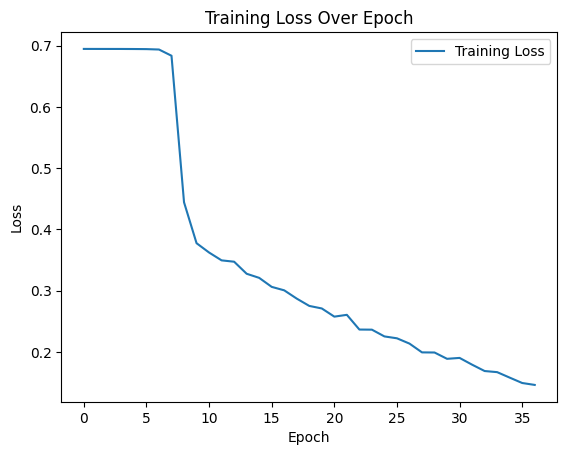

In [22]:
import matplotlib.pyplot as plt
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epoch")
plt.legend()

plt.show()


In [23]:
import torch
# Save model checkpoint

torch.save(Classifier, 'is_conversation_embedding_classifier_doubles.pt')